## Data Wrangling "WeRateDogs* 

# Project: Wrangling and Analyze Data

#### Table of Contents
- Introduction
- Gather Data
- Assess the Data
- Clean the Data
- Visualization and Analysis
- Conclusions

#### Introduction

This project makes part of the coursework leading to Udacity's Data Analysis Nanodegree (DAND). Its objective is to demonstrate skills for the Data Wrangling phase of the Data Analysis Process. Data Wrangling is a key part in analytics, and is typically described as the one where analysts and data scientists spend the most part of their time.

The project gathers data from different sources related to the WeRateDogs twitter account, which posts and rates photos of folowers' dogs. After assessing and cleaning the data, reports are written to communicate the results of an initial analysis.

In [246]:
# Import the libraries needed for this project
import pandas as pd
import numpy as np
import requests
import zipfile
import seaborn as sns
import os
import tweepy
import json
import re
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from IPython.display import HTML
from PIL import Image
from io import BytesIO
from wordcloud import WordCloud, STOPWORDS
plt.style.use('bmh')
%matplotlib inline

## Data Gathering


### 1) Tweets Data

In [247]:
# Create Pandas dataframe from the tweets csv file inside the data folder
tweets_df = pd.read_csv('twitter-archive-enhanced.csv')

In [248]:
# Exploration of data in file
tweets_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [249]:
# Exploring for data and checking for missing ones
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### 2) Dog Image Predictions

In [250]:
# Download image predictions using requests module
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response.raise_for_status()

In [251]:
#save image predictions data to as 'image-predictions.tsv' file in the 'data' folder 
with open('image_predictions.tsv',mode = 'wb') as file:
    file.write(response.content)

In [252]:
# Creating dataframe from the image predictions data
image_predictions_df = pd.read_csv('image_predictions.tsv', sep='\t')

In [253]:
# Exploring the predictions data
image_predictions_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [254]:
# Exploring of data and checking for missing ones
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### 3. The Twitter API 

In [255]:
# Using Authentication process 
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth,parser=tweepy.parsers.JSONParser(), wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [256]:
twitter_API_df = pd.read_csv('twitter_archive_master.csv')

## Assessing Data

In [257]:
tweets_df.info()
tweets_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,89024025534

In [258]:
# statistic description of tweets_df
tweets_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [259]:
# data sample 
tweets_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2059,671186162933985280,NaN,NaN,2015-11-30 04:37:05 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sparky. That's his pancake now. He will raise it as his own. 10/10 https://t.co/96tMaWyoWt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671186162933985280/photo/1,10,10,Sparky,None,None,None,None
1595,686358356425093120,NaN,NaN,2016-01-11 01:25:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Heartwarming scene here. Son reuniting w father after coming home from deployment. Very moving. 10/10 for both pups https://t.co/95JJevQOWW,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686358356425093120/photo/1,10,10,None,None,None,None,None
643,793195938047070209,NaN,NaN,2016-10-31 21:00:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Lily. She's pupset that her costume doesn't fit as well as last year. 12/10 poor puppo https://t.co/YSi6K1firY,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/793195938047070209/photo/1,https://twitter.com/dog_rates/status/793195938047070209/photo/1",12,10,Lily,None,None,None,puppo
1387,700505138482569216,NaN,NaN,2016-02-19 02:20:14 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Kaia. She's just cute as hell. 12/10 I'd kill for Kaia https://t.co/5fMdH8GFaq,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/700505138482569216/photo/1,https://twitter.com/dog_rates/status/700505138482569216/photo/1,https://twitter.com/dog_rates/status/700505138482569216/photo/1,https://twitter.com/dog_rates/status/700505138482569216/photo/1",12,10,Kaia,None,None,None,None
1992,672614745925664768,NaN,NaN,2015-12-04 03:13:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Norman. Doesn't bark much. Very docile pup. Up to date on current events. Overall nifty pupper. 6/10 https://t.co/ntxsR98f3U,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672614745925664768/photo/1,6,10,Norman,None,None,pupper,None


In [260]:
tweets_df.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [261]:
# check for source column
tweets_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

In [262]:
# check for the dog's name written style
tweets_df.name.str.istitle().value_counts()

True     2241
False    115 
Name: name, dtype: int64

In [263]:
# check for those written as lowercase
lowers = tweets_df.name.loc[tweets_df.name.str.islower()].unique()
lowers

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [264]:
# check for the unique values of those non titled
untitled = tweets_df.name.loc[tweets_df.name.str.istitle() == False].unique()
untitled

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'BeBe', 'mad',
       'an', 'very', 'just', 'DonDon', 'my', 'his', 'actually', 'getting',
       'this', 'unacceptable', 'all', 'old', 'infuriating', 'CeCe', 'the',
       'by', 'officially', 'life', 'light', 'space', 'JD', 'DayZ'], dtype=object)

In [265]:
# check for those mis-written 
untitled_unlowers = [i for i in untitled if  i not in lowers]  
untitled_unlowers

['BeBe', 'DonDon', 'CeCe', 'JD', 'DayZ']

In [266]:
# check for denominator values below 10
pd.set_option('display.max_colwidth',-1)
tweets_df.loc[tweets_df.rating_denominator <10 , ['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
2335,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2


In [267]:
# check for rating denominator values > 10
tweets_df.loc[tweets_df.rating_denominator >10 ,['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80


In [268]:
# check for rating_numerator <10
tweets_df.loc[tweets_df.rating_numerator < 10,['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
229,"This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1",6,10
315,When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,0,10
387,"I was going to do 007/10, but the joke wasn't worth the &lt;10 rating",7,10
462,RT @dog_rates: Meet Herschel. He's slightly bigger than ur average pupper. Looks lonely. Could probably ride 7/10 would totally pet https:/…,7,10
485,RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https:/…,9,10
599,RT @dog_rates: Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.…,8,10
605,RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…,1,10
730,Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC,5,10
745,RT @dog_rates: This is Hank. He's mischievous af. Doesn't even know what he was trying to do here. 8/10 quit the shit Hank damn https://t.c…,8,10


In [269]:
# check for rating_numerator values > 10
tweets_df.loc[tweets_df.rating_numerator > 14,['text','rating_numerator','rating_denominator']]

,text,rating_numerator,rating_denominator
55,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,17,10
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10
189,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,10
285,RT @KibaDva: I collected all the good dogs!! 15/10 @dog_rates #GoodDogs https://t.co/6UCGFczlOI,15,10
290,@markhoppus 182/10,182,10
291,@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10,15,10
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7


In [270]:
# check for the text 
tweets_df.text.sample(5).tolist()

['Say hello to Sadie and Daisy. They do all their shopping together. Can never agree on what to get. Like an old married pupple. Both 12/10 https://t.co/f5C5l5wa0e',
 'RT @dog_rates: This is Scout. He really wants to kiss himself. H*ckin inappropriate. 11/10 narcissistic af https://t.co/x0gV2Ck3AD',
 'This is Toby. A cat got his tongue. 13/10 adorable af https://t.co/fHQrBKYSLC',
 "This is Severus. He's here to fix your cable. Looks like he succeeded. Even offered to pupgrade your plan. 13/10 h*ckin helpful https://t.co/aX4brLLpWZ",
 '12/10 stay woke https://t.co/XDiQw4Akiw']

In [271]:
# check inside the text values for non dog related tweets
tweets_df.text[tweets_df.text.str.match('.*only rate dogs')]

25      This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp         
59      Ugh not again. We only rate dogs. Please don't send in well-dressed  floppy-tongued street penguins. Dogs only please. Thank you... 12/10 https://t.co/WiAMbTkDPf 
93      I can't believe this keeps happening. This, is a birb taking a bath. We only rate dogs. Please only send dogs. Thank you... 12/10 https://t.co/pwY9PQhtP2         
118     RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…                      
127     Unbelievable. We only rate dogs. Please don't send in non-canines like the "I" from Pixar's opening credits. Thank you... 12/10 https://t.co/JMhDNv5wXZ           
131     Oh my this spooked me up. We only rate dogs, not happy ghosts. Please send dogs only. It's a very simple premise. Thank you... 13/10 http

In [272]:
# check the expanded urls column
tweets_df.expanded_urls.sample(5)

650     https://twitter.com/dog_rates/status/792883833364439040/photo/1,https://twitter.com/dog_rates/status/792883833364439040/photo/1,https://twitter.com/dog_rates/status/792883833364439040/photo/1,https://twitter.com/dog_rates/status/792883833364439040/photo/1
2003    https://twitter.com/dog_rates/status/672475084225949696/photo/1                                                                                                                                                                                                
579     https://twitter.com/dog_rates/status/800513324630806528/photo/1                                                                                                                                                                                                
1609    https://twitter.com/dog_rates/status/685547936038666240/photo/1,https://twitter.com/dog_rates/status/685547936038666240/photo/1                                                                         

In [273]:
# check for how many time this issue occur?
len(tweets_df.text[tweets_df.text.str.match('.*only rate dogs')])

64

In [274]:
image_predictions_df.info()
image_predictions_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [275]:
# statistic description of image_predictions_df
image_predictions_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [276]:
# data sample 
image_predictions_df.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1906,852311364735569921,https://pbs.twimg.com/media/C9QEqZ7XYAIR7fS.jpg,1,barbell,0.971581,False,dumbbell,0.028418,False,go-kart,5.595040e-07,False
183,669353438988365824,https://pbs.twimg.com/media/CUoFZTyW4AE70iD.jpg,1,teddy,0.379656,False,Pembroke,0.212343,True,chow,9.699530e-02,True
1405,769940425801170949,https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg,1,miniature_pinscher,0.796313,True,Chihuahua,0.155413,True,Staffordshire_bullterrier,3.094330e-02,True
672,683142553609318400,https://pbs.twimg.com/media/CXsChyjW8AQJ16C.jpg,1,Leonberg,0.605851,True,chow,0.183470,True,German_shepherd,7.966190e-02,True
601,679777920601223168,https://pbs.twimg.com/media/CW8OYajUMAAPRoF.jpg,1,bloodhound,0.528819,True,bull_mastiff,0.420119,True,French_bulldog,9.480590e-03,True


In [277]:
# number of dogs breeds
image_predictions_df.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                     89 
Chihuahua                    83 
pug                          57 
chow                         44 
Samoyed                      43 
toy_poodle                   39 
Pomeranian                   38 
malamute                     30 
cocker_spaniel               30 
French_bulldog               26 
miniature_pinscher           23 
Chesapeake_Bay_retriever     23 
seat_belt                    22 
Siberian_husky               20 
Staffordshire_bullterrier    20 
German_shepherd              20 
Cardigan                     19 
web_site                     19 
teddy                        18 
Eskimo_dog                   18 
Maltese_dog                  18 
beagle                       18 
Shetland_sheepdog            18 
Lakeland_terrier             17 
Shih-Tzu                     17 
Rottweiler                   17 
kuvasz                       16 
Italian_greyhound            16 
          

In [278]:
twitter_API_df.info()
twitter_API_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 196.7+ KB


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,None,None,None
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,None,None,None
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,None,None,None
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,None,None,None
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitt

In [279]:
# twitter_API_df statistics
twitter_API_df.describe()

,tweet_id,rating_numerator,rating_denominator
count,2.097000e+03,2097.000000,2097.000000
mean,7.365594e+17,12.189318,10.448736
std,6.710178e+16,40.364996,6.645061
min,6.660209e+17,0.000000,2.000000
25%,6.768197e+17,10.000000,10.000000
50%,7.098528e+17,11.000000,10.000000
75%,7.877176e+17,12.000000,10.000000
max,8.924206e+17,1776.000000,170.000000


In [280]:
# data sample 
twitter_API_df.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1956,668587383441514497,2015-11-23 00:30:28 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3,https://vine.co/v/ea0OwvPTx9l,13,10,the,None,None,None,None
1700,673686845050527744,2015-12-07 02:13:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is George. He's upset that the 4th of July isn't everyday. 11/10 https://t.co/wImU0jdx3E,https://twitter.com/dog_rates/status/673686845050527744/photo/1,11,10,George,None,None,None,None
510,789903600034189313,2016-10-22 18:57:48 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",This is Ralphy. His dreams were just shattered. Poor pupper. 13/10 it'll be ok Ralphy https://t.co/P0kSN6rT6H,https://vine.co/v/5wPT1aBxPQZ,13,10,Ralphy,None,None,pupper,None
1554,677331501395156992,2015-12-17 03:36:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Humphrey. He's a Northern Polyp Viagra. One ear works. Face stuck like that. Always surprised. 9/10 petable af https://t.co/FS7eJQM2F4,https://twitter.com/dog_rates/status/677331501395156992/photo/1,9,10,Humphrey,None,None,None,None
117,865718153858494464,2017-05-19 23:57:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Boomer. He's just checking pup on you. Hopes you had a good day. If not, he hopes he made it better. 13/10 extremely good boy https://t.co/pozUoHLkGg",https://twitter.com/dog_rates/status/865718153858494464/photo/1,13,10,Boomer,None,None,None,None


In [281]:
# check for datasets shape and completeness
tweets_df.shape[0], twitter_API_df.shape[0] , image_predictions_df.shape[0]

(2356, 2097, 2075)

In [282]:
# duplicate columns in the three datasets
all_columns = pd.Series(list(tweets_df) + list(twitter_API_df) +list(image_predictions_df))
all_columns[all_columns.duplicated()]

17    tweet_id          
18    timestamp         
19    source            
20    text              
21    expanded_urls     
22    rating_numerator  
23    rating_denominator
24    name              
25    doggo             
26    floofer           
27    pupper            
28    puppo             
29    tweet_id          
dtype: object

# Quality issues
* tweets_df

* Missing Values :

- in_reply_to_status_id, in_reply_to_user_id : 78 instead of 2356

- retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp 181 instead of 2356

- expanded_urls : 2297 instead of 2356
- We are interested in the tweet ONLY not the retweet
- We are interested in the tweet ONLY not the reply to the original tweet

- tweet_id is saved as int datatype instead of/ "better to be" string (object)

- timestamp , retweeted_status_timestamp are saved as object datatype (str) instead of date/timestamp

- source column is writen in html containg <a> tags
- column name :

some values are not titled untitled_unlowers ('BeBe','DonDon','CeCe',, 'JD', 'DayZ')
some are inacuarte values : lowers ['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad','an', 'very', 'just', 'my', 'his', 'actually', 'getting','this', 'unacceptable', 'all', 'old', 'infuriating', 'the','by', 'officially', 'life', 'light', 'space']


* rating_numerator & rating_denominator:

datatype for rating_numerator should be float instead of int
fix:
@45 13.5/10 instead of 5/10
@ 313 13/10 instead of 960/0
@ 2335 : 9/10 instead of 1/2
@ 1068 : 14/10 instead of 9/11
@1165: 13/10 instead of 4/20
@ 1202 : 11/10 instead of 50/50
@ 1662 10/10 instead of 7/11
@ 695 : 9.75/10 instead of 75/10
@763 : 11.27/10 instead of 27/10
@1712 :11.26/10 instead of 26/10
drop:
@ 516 no rating
@342 inaccurate (account start date)
invistigate(outliers):
@ 315 https://t.co/YbEJPkg4Ag 0/10
@979 1776/10
@ 1634 : https://t.co/kRK51Y5ac3 143/130
@2074 :420/10
@1274 names

- columns doggo,floofer,pupper, puppo has None values instead of Null.

- some tweets are retweets or replies. 


- expanded_urls is too bulky we are interested in tweet link only.


* image_pred
- some images are not for dogs
- tweet_id is saved as int datatype instead of object datatype
- replace the underscore in breeds values with space and title all breeds values (p1 & p2 & p3)


* twitter_json
- column id is saved as int datatype instead of object datatype & rename as tweet_id


* All_datasets
- we have completeness issue not all the datasets have the same number of observation

### Tidiness issues

1. twitter_archive

    - text column has two variables text and short urls,create short_urls column, drop expanded_urls

    - The values of four columns (doggo,floofer,pupper,puppo) in twitter_archive dataset should be in one column dog_stage with a category datatype.
    - rating_numerator and rating_denominator columns in twitter_archive dataset should form one column dog_rating normalized out of 10.
    - make new columns for day_name and month from the timstamp column
    

2. image_pred

    - Columns p1, p1_dog, p1_conf , p2, p2_dog, p2_conf , p3, p3_dog, p3_conf could be condenced to two columns dog_breed and confidence
    

3. All datasets

    - tweet_id is present in two datasets and after renaming it will appear in all datasets
    - twitter_API and image_predictions datasets should be part of our main dataset twitter_archive.

## Cleaning Data


In [325]:
tweets_df_clean=tweets_df.copy()
image_predictions_df_clean=image_predictions_df.copy()
twitter_API_df_clean=twitter_API_df.copy()

#### Issue (Missing Values):

twitter_archive

- Missing Values :

- in_reply_to_status_id, in_reply_to_user_id : 78 instead of 2356
- retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp 181 instead of 2356
- expanded_urls : 2297 instead of 2356 (to be fixed later) #### Define
- in the twitter_archive dataset we will keep only recodrs that:
- 1 Are not associated with retweets.
- 2 Are not associated with reply to the original tweet.
- i.e we will keep the NaN values for these columns and drop non NaN values
- Drop columns:
- in_reply_to_status_id
- in_reply_to_user_id
- retweeted_status_id
- retweeted_status_user_id
- retweeted_status_timestamp**

#### Code

In [284]:
tweets_df_clean = tweets_df_clean.query('in_reply_to_status_id == "NaN" &\
                                                     in_reply_to_user_id == "NaN" &\
                                                    retweeted_status_id == "NaN" &\
                                                    retweeted_status_user_id == "NaN"')
# drop columns
xcolumns = ['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id',
           'retweeted_status_user_id', 'retweeted_status_timestamp']
tweets_df_clean = tweets_df_clean.drop(columns = xcolumns, axis=1)

#### Test

In [285]:
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


#### Issue (twitter_archive) :
text column has two variables text and short urls,create short_urls column, drop expanded_urls

#### Define

* use split method by ' ' over the text column, and apply over row
* create short_urls column
* drop expanded_urls column
* split the text column by https: and assign its value to the same column name

#### Code

In [286]:
# create short_urls column by use split method over the text column, and apply over row
tweets_df_clean ['short_urls'] = tweets_df_clean.text.apply(lambda x :x.strip().split(' ')[-1])
# drop the expanded_urls
tweets_df_clean.drop('expanded_urls', axis =1, inplace=True)
# split the text column by `https:` and assign its value to the same column name
tweets_df_clean.text = tweets_df_clean.text.apply(lambda x:x.split('https:')[0])

#### Test

In [288]:
tweets_df_clean.sample()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,short_urls
858,763837565564780549,2016-08-11 20:40:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Alfie. He's touching a butt. Couldn't be happier. 11/10,11,10,Alfie,None,None,None,None,https://t.co/gx3xF5mZbo


#### Issue (twitter_archive):

* The values of four columns (doggo,floofer,pupper,puppo) in twitter_archive dataset should be in one column dog_stage with a category datatype.


#### Define

- select the last 4 columns related to the different dog stages
- replace the 'None' string with np.nan in the selected columns
- create a dog_stage column joinig all the values in the selected values droping nan, convert to str
- convert the dog_stage column type to categorical
- drop the columns related to the previous 4 stages

#### code

In [289]:
# select the dog stages columns from the dataset
all_dogs_type = ['doggo', 'floofer', 'pupper', 'puppo']
# replace the 'None' string with np.nan 
tweets_df_clean [all_dogs_type] = tweets_df_clean [all_dogs_type].replace('None', np.nan)

# create the dog_stage column with joining the four columns in one column dog_stage join for more than stage
tweets_df_clean ['dog_stage'] = tweets_df_clean [all_dogs_type].\
                                        apply(lambda x: ', '.join(x.dropna().astype(str)),axis =1)
# replace the empty string with nan and change datatype to category
tweets_df_clean.dog_stage = tweets_df_clean.dog_stage.replace('', np.nan).astype('category')

# drop the 4 columns
tweets_df_clean = tweets_df_clean.drop(columns = all_dogs_type, axis =1)

#### test

In [290]:
# check for the data columns and datatype
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
short_urls            2097 non-null object
dog_stage             336 non-null category
dtypes: category(1), int64(3), object(5)
memory usage: 149.9+ KB


In [291]:
# check for the values of the new column
tweets_df_clean.dog_stage.value_counts()

pupper            221
doggo             72 
puppo             23 
floofer           9  
doggo, pupper     9  
doggo, puppo      1  
doggo, floofer    1  
Name: dog_stage, dtype: int64

#### Issue (Rating_numerator & Rating_denominator) :

datatype for rating_numerator should be float instead of int


#### Define
convert the datatype of rating_numerator to float by astype('float').

##### Code

In [292]:
#convert the datatype of rating_numerator to float by astype('float')
tweets_df_clean.rating_numerator = tweets_df_clean.rating_numerator.astype('float')

#### test

In [293]:
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
rating_numerator      2097 non-null float64
rating_denominator    2097 non-null int64
name                  2097 non-null object
short_urls            2097 non-null object
dog_stage             336 non-null category
dtypes: category(1), float64(1), int64(2), object(5)
memory usage: 149.9+ KB


#### Issue (Rating_numerator & Rating_denominator):

- fix:
 - @45 13.5/10 instead of 5/10
 - @ 313 13/10 instead of 960/0
 - @ 2335 : 9/10 instead of 1/2
 - @ 1068 : 14/10 instead of 9/11
 - @1165: 13/10 instead of 4/20
 - @ 1202 : 11/10 instead of 50/50
 - @ 1662 10/10 instead of 7/11
 - @ 695 : 9.75/10 instead of 75/10
 - @763 : 11.27/10 instead of 27/10
 - @1712 :11.26/10 instead of 26/10

- drop:
 - @ 516 no rating
 - @342 inaccurate (account start date) retweets& replys are already droped

#### Define
- check for the above indices if exist
- get a list of the indices of the erros after check
- set a list for the correct values relative to those indices
- loop through the two lists and assign each index with the new correct value
- drop [516] by index

#### code

In [294]:
# check for index if exist
indices = [45,313,2335,1068,1165,1202,1662,695,763,1712,516,342]
for i in indices:
    if i in list(tweets_df_clean.index):
        print('yes')
    else: 
        print(f'No : {i} ')

yes
No : 313 
yes
yes
yes
yes
yes
yes
yes
yes
yes
No : 342 


In [295]:
#get a list of the indices of the erros after check
indices = [45,2335,1068,1165,1202,1662,695,763,1712]

# set a list for the correct values relative to those indices
vals = [13.5,9,14,13,11,10,9.75,11.27,11.26]

# loop through the two lists and assign each index with the new correct value
for i,val in zip(indices,vals):
    tweets_df_clean.loc[i, 'rating_numerator'] = val
    tweets_df_clean.loc[i, 'rating_denominator'] =10
# drop the index: 516 
tweets_df_clean.drop(index=516,inplace=True)

#### Test

In [296]:
# test for value for one of the entries
assert tweets_df_clean.loc[1712,'rating_numerator'] ==11.26

# test for droping index=516
assert 516 not in list(tweets_df_clean.index)

In [297]:
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2096 non-null int64
timestamp             2096 non-null object
source                2096 non-null object
text                  2096 non-null object
rating_numerator      2096 non-null float64
rating_denominator    2096 non-null int64
name                  2096 non-null object
short_urls            2096 non-null object
dog_stage             336 non-null category
dtypes: category(1), float64(1), int64(2), object(5)
memory usage: 229.8+ KB


In [298]:
# check for the rating_denominator values
tweets_df_clean.rating_denominator.value_counts()

10     2085
80     2   
50     2   
170    1   
150    1   
120    1   
110    1   
90     1   
70     1   
40     1   
Name: rating_denominator, dtype: int64

#### Issue (twitter_archive): 

rating_numerator and rating_denominator columns in twitter_archive dataset should form one column dog_rating normalized out of 10.

#### Define
- divide the rating_numerator / rating_denominator and then mulitiply by 10
- make dog_score column
- drop the columns rating_numerator & rating_denominator column

#### Code

In [299]:
#divide the rating_numerator / rating_denominator and then mulitiply by 10 & make dog_score column
tweets_df_clean ['dog_score'] = 10 * tweets_df_clean.rating_numerator / tweets_df_clean.rating_denominator


#drop the columns rating_numerator & rating_denominator column
tweets_df_clean.drop(['rating_numerator','rating_denominator'],axis=1,inplace=True)

#### Test

In [300]:
# check for the tweets_df_clean data
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2096 entries, 0 to 2355
Data columns (total 8 columns):
tweet_id      2096 non-null int64
timestamp     2096 non-null object
source        2096 non-null object
text          2096 non-null object
name          2096 non-null object
short_urls    2096 non-null object
dog_stage     336 non-null category
dog_score     2096 non-null float64
dtypes: category(1), float64(1), int64(1), object(5)
memory usage: 213.4+ KB


In [301]:
# check for values in the dog_score column
tweets_df_clean.dog_score.value_counts()

12.00      490
10.00      438
11.00      419
13.00      288
9.00       154
8.00       98 
7.00       51 
14.00      39 
5.00       33 
6.00       32 
3.00       19 
4.00       15 
2.00       9  
1.00       4  
9.75       1  
0.00       1  
11.26      1  
11.27      1  
13.50      1  
420.00     1  
1776.00    1  
Name: dog_score, dtype: int64

#### Issue (Fix the tweet_id columns in all datasets)


#### Define

- rename the id column in twitter_json to tweet_id
- change the datatype to str(object) for tweet_id column in all datasets

#### Code

In [302]:
# change the datatype to str(object) in all datasets
datasets = [tweets_df_clean,image_predictions_df_clean,twitter_API_df_clean]
for i in datasets:
    i.tweet_id = i.tweet_id.astype('object')

#### Test

In [303]:
# check for the datatypes for tweet_id in all datasets
for i in datasets:
    assert i.tweet_id.dtypes == 'object'

#### Issue 
image_pred dataset condence the columns p1,p1_dog_p1_conf,...etc to dog_breed, confidence

we are interested in images of dogs only
we are are going to select those have at least one prediction for dog among the top three prediction

#### Define
- define a dog_breed_confidence function to extract the dog_breed and confience from the top 3 predictions
- apply the function row wise
- assign the new column names dog_breed and confidence
- drop the unneeded columns now
- rename the No breed values with np.nan
- replace the underscore with space and title all breeds values

#### Code

In [304]:
breed = []
confidence = []

# define the function
def dog_breed_confidence(data):
    if data.p1_dog:
        breed.append(data.p1)
        confidence.append(data.p1_conf)
    elif data.p2_dog:
        breed.append(data.p2)
        confidence.append(data.p2_conf)
    elif data.p3_dog :
        breed.append(data.p3)
        confidence.append(data.p3_conf)
    else:
        breed.append('No breed')
        confidence.append(0)
# apply the function row wise        
image_predictions_df_clean.apply(dog_breed_confidence,axis =1)
# assign the new column names
image_predictions_df_clean['dog_breed'] = breed
image_predictions_df_clean['confidence'] = confidence
# drop the un needed columns now
image_predictions_df_clean.drop(columns = ['p1', 'p1_dog', 'p1_conf' , 'p2', 'p2_dog',
                                 'p2_conf' , 'p3', 'p3_dog', 'p3_conf'],axis=1, inplace =True)
# rename the No breed values with np.nan
image_predictions_df_clean.replace('No breed',np.nan, inplace=True)
# replace the underscore with space and title all breeds values
image_predictions_df_clean.dog_breed= image_predictions_df_clean.dog_breed.str.replace('_',' ').str.title()

#### Test

In [305]:
image_predictions_df_clean.head()

,tweet_id,jpg_url,img_num,dog_breed,confidence
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311


#### Issue 
- twitter_API_df and image_predictions_df datasets should be part of our main dataset twitter_archive.

- we are interested in the retweet_count and favorite_count from twitter_API_df and keeping the original data
- we are interested in the tweets that have images

#### Define
- use the merge function to merge tweets_df_clean and twitter_API_df_clean on tweet_id column (left join)
- use the merge function to merge tweets_df_clean and image_predictions_df_clean on tweet_id column (inner join)
- make the master dataset

#### Code

In [306]:
# use the merge function to merge tweets_df_clean and twitter_API_df_clean on tweet_id column (left join)
tweets_df_clean = pd.merge(tweets_df_clean, twitter_API_df_clean , how = 'left' , on = 'tweet_id')

# use the merge function to merge tweets_df_clean and image_predictions_df_clean on tweet_id column (inner join) 
# and make master dataset
master_dataset = pd.merge(tweets_df_clean, image_predictions_df_clean , how = 'inner' , on = 'tweet_id')

ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

#### Test

In [307]:
# check new dataset after merge 
master_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2388 entries, 0 to 2387
Data columns (total 43 columns):
tweet_id                      2388 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2388 non-null datetime64[ns]
source                        2388 non-null object
text                          2388 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2388 non-null object
rating_numerator              2388 non-null int64
rating_denominator            2388 non-null int64
dog_name                      2388 non-null object
doggo                         2388 non-null object
floofer                       2388 non-null object
pupper                        2388 non-null object
puppo                         2388 non-null object
tweet_date                 

In [308]:
# check that all records have an image
master_dataset.jpg_url.isnull().sum()

0

#### Issue 
Source column is written in html containg <a> tags

#### Define
- Check for the unique values in source columns to know how to extract the needed value
- Make a function fix_source which extract the strings between tags (>text<)
- Use apply function to fix the source column row wise

#### Code

In [309]:
#make a function fix_source which extract the strings between tags
def fix_source(i):
    'i is an html string from the source column in tweets_df_clean dataset'
    #find the first closed  tag >
    x= i.find('>') + 1
    # find the first open tag after the previous <
    y =i[x:].find('<')
    # extract the text in between
    return i[x:][:y]

In [310]:
# use apply function to fix the source column row wise
master_dataset.source= master_dataset.source.apply(lambda x: fix_source(x))

#### Test

In [311]:
# check for the result values in the source column
master_dataset.source.value_counts()

Twitter for iPhon    2344
Twitter Web Clien    31  
TweetDec             13  
Name: source, dtype: int64

#### Issue 
Timestamp is saved as object datatype (str) instead of date/timestamp

#### Define
Change the datatype of timestamp column to datetime

###### Code

In [312]:
# change the datatype of timestamp column to datetime 
master_dataset.timestamp = pd.to_datetime(master_dataset.timestamp)

#### Test

In [313]:
# check for the datatype
master_dataset.timestamp.dtype

dtype('<M8[ns]')

#### Issue 
- Make new columns for day_name and month for more analysis

#### Define
- Extract the month name from the timestamp column
- Extract the day name from the timestamp column

#### Code

In [314]:
# extract the month name
master_dataset['month'] = master_dataset.timestamp.apply(lambda x: x.month_name())

#extarct the day_name
master_dataset['day_name'] = master_dataset.timestamp.apply(lambda x: x.day_name())

#### Test

In [315]:
master_dataset.loc[:5,['timestamp','day_name','month']]

,timestamp,day_name,month
0,2017-08-01 16:23:56,Tuesday,August
1,2017-08-01 00:17:27,Tuesday,August
2,2017-07-31 00:18:03,Monday,July
3,2017-07-30 15:58:51,Sunday,July
4,2017-07-29 16:00:24,Saturday,July
5,2017-07-29 00:08:17,Saturday,July


In [318]:
# Check for the datatypes
master_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2388 entries, 0 to 2387
Data columns (total 43 columns):
tweet_id                      2388 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2388 non-null datetime64[ns]
source                        2388 non-null object
text                          2388 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2388 non-null object
rating_numerator              2388 non-null int64
rating_denominator            2388 non-null int64
dog_name                      2388 non-null object
doggo                         2388 non-null object
floofer                       2388 non-null object
pupper                        2388 non-null object
puppo                         2388 non-null object
tweet_date                 

#### Issue 
Column name:

- rename to dog_name
- some values are not titled untitled_unlowers ('BeBe','DonDon','CeCe',, 'JD', 'DayZ')
- some are inacuarte values : lowers ['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad','an', 'very', 'just', 'my', 'his', 'actually', 'getting','this', 'unacceptable', 'all', 'old', 'infuriating', 'the','by', 'officially', 'life', 'light', 'space']


#### Define
- Rename the column to dog_name
- Relace 'None' values with np.nan values

#### Code

In [319]:
# rename the name column to dog_name
master_dataset.rename(columns={'name':'dog_name'},inplace=True)

# replace 'None' with np.nan values
master_dataset.dog_name.replace('None', np.nan, inplace= True)

#### Test

In [320]:
# check for data names
master_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2388 entries, 0 to 2387
Data columns (total 43 columns):
tweet_id                      2388 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2388 non-null datetime64[ns]
source                        2388 non-null object
text                          2388 non-null object
retweeted_status_id           81 non-null float64
retweeted_status_user_id      81 non-null float64
retweeted_status_timestamp    81 non-null object
expanded_urls                 2388 non-null object
rating_numerator              2388 non-null int64
rating_denominator            2388 non-null int64
dog_name                      2388 non-null object
doggo                         2388 non-null object
floofer                       2388 non-null object
pupper                        2388 non-null object
puppo                         2388 non-null object
tweet_date                 

#### Issue 
Some tweets are retweets or replies


#### Define
Remove all observations in ttweets_df_clean dataset that have values in the rows in_reply_to_status_id or retweeted_status_id. Then remove those two columns plus retweeted_status_user_id, retweeted_status_timestamp and in_reply_to_user_id




#### Code

In [326]:
tweets_df_clean = tweets_df_clean[(tweets_df_clean['in_reply_to_status_id'].isna() == True)  & (tweets_df_clean['retweeted_status_id'].isna() == True)]

tweets_df_clean = tweets_df_clean.drop(['in_reply_to_status_id',
                              'in_reply_to_user_id',
                              'retweeted_status_id',
                              'retweeted_status_user_id',
                              'retweeted_status_timestamp'],
                            axis = 1)

#### Test

In [327]:
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


#### Final Test

In [328]:
tweets_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


In [329]:
image_predictions_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## Storing Data
Store the clean DataFrame tweets_df_clean in a CSV file named twitter_archive_master.csv and image_predictions_df_clean in additional file 'image_predictions.tsv'.

In [330]:
master_dataset.to_csv('twitter_archive_master.csv',encoding='utf-8',index=False)

In [331]:
# Save a copy of the dataframe to csv for future reference\n",
tweets_df_clean.to_csv('twitter_archive_master.csv', encoding='utf-8',index=False)

In [332]:
df_clean = pd.read_csv('twitter_archive_master.csv')

In [333]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 12 columns):
tweet_id              2097 non-null int64
timestamp             2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
dtypes: int64(3), object(9)
memory usage: 196.7+ KB


In [334]:
df_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


## Analyzing and Visualizing Data

#### 1) Imports

In [335]:
# Import visualization libraries\n"
import matplotlib.pyplot as plt
import seaborn as sns
    
# 'Magic word' so that your visualizations are plotted
% matplotlib inline
   
# Set style of plots with seaborn
sns.set(style="darkgrid",font_scale=1.5)


2) The questions we want to answer:

- Which is the most popular day/month to post a dog photo? 
    
- What's the most source used by followers to share their dog's nice photo ?
   
- Which is the most common breed?


- Which is the most popular day/month to post a dog photo?

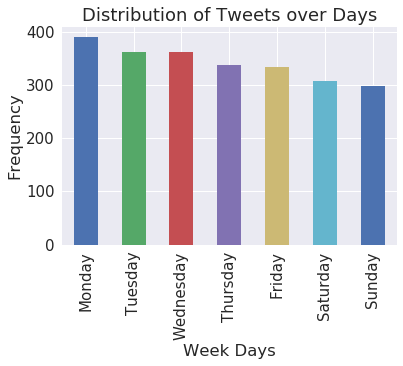

In [337]:
master_dataset.day_name.value_counts().plot('bar')
plt.title("Distribution of Tweets over Days")
plt.xlabel('Week Days')
plt.ylabel('Frequency');

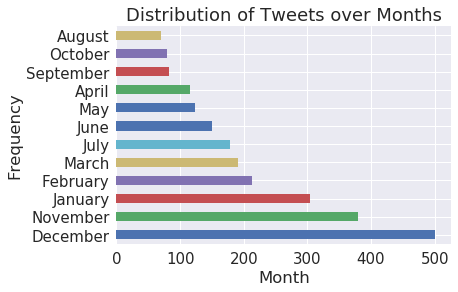

In [344]:
master_dataset.month.value_counts().plot('barh')
plt.title("Distribution of Tweets over Months")
plt.xlabel('Month')
plt.ylabel('Frequency');

- It is quiet clear that people tend to post their dogs photos in Monday/ December
    - Interestingly, most day is Monday, may indicate that most of followers is out of stress (may be not workers)


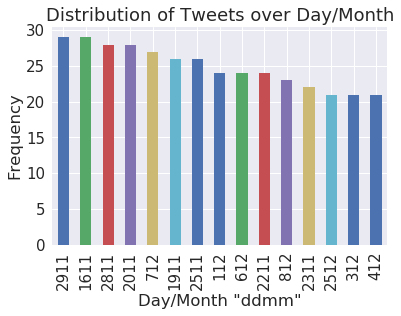

In [339]:
# select the month and day from timestamp e.g 01/07 will be 107
master_dataset.timestamp.apply(lambda x:  x.day*100 + x.month ).value_counts().sort_values(ascending =False)[:15].plot('bar')
plt.title("Distribution of Tweets over Day/Month")
plt.xlabel('Day/Month "ddmm"')
plt.xticks(rotation = 90)
plt.ylabel('Frequency');

- What's the most source used by followers to share their dog's nice photo ?

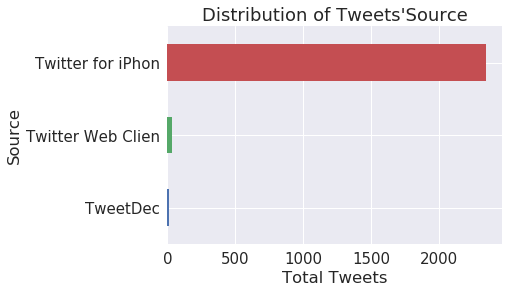

In [340]:
plt.title("Distribution of Tweets'Source")
master_dataset.source.value_counts().sort_values().plot(kind ='barh')
plt.xlabel('Total Tweets')
plt.ylabel('Source');

In [341]:
# percentage of sources
master_dataset.source.value_counts() / master_dataset.source.value_counts().sum()

Twitter for iPhon    0.981575
Twitter Web Clien    0.012982
TweetDec             0.005444
Name: source, dtype: float64

It is clear from the above that Twitter app in Iphone has the most share 98% which is better explained by :

- The ease of use to take a shot for a dog from the app
- The high resolution of cameras.

- Which is the most common breed?

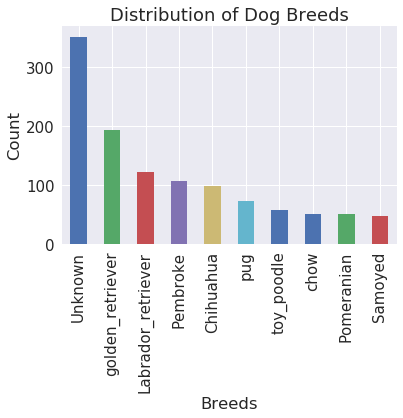

In [345]:
# frequency for dog breeds
master_dataset.dog_breed.value_counts()[:10].plot('bar')
plt.title('Distribution of Dog Breeds')
plt.xlabel('Breeds')
plt.ylabel('Count');

Here, The most common breed in our sample is Unknown and Golden Retriever


- The breeds data contains a lot of null values
- Also to take into consideration that this data is given by a neural network model

### Insights:
1. It is quiet clear that people tend to post their dogs photos in Mondy/ December. Which may indicate that most of followers is out of stress.

2. Using Twitter through iphone to share dog's photoes represent 98% due to the high resolution of cameras.

3. golden_retriever, Labrador_retriever and Pembroke are considered the most Dog Breeds distribute around the countries.